In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 208 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 10.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.densenet import DenseNet121 as densenet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as mobilenetv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [21]:
train_df = pd.read_csv("files/densenet121/covid/glcm_results/covid_homogeneity_above_glcm_above.csv")
train_df2 = pd.read_csv("files/densenet121/covid/glcm_results/covid_homogeneity_above_glcm_below.csv")

In [22]:
print(train_df2)

                                   file      label
0                   covid/COVID-553.png      covid
1                   covid/COVID-504.png      covid
2                   covid/COVID-176.png      covid
3                   covid/COVID-732.png      covid
4                    covid/COVID-96.png      covid
...                                 ...        ...
2103  pneumonia/Viral Pneumonia-307.png  pneumonia
2104  pneumonia/Viral Pneumonia-210.png  pneumonia
2105  pneumonia/Viral Pneumonia-409.png  pneumonia
2106  pneumonia/Viral Pneumonia-339.png  pneumonia
2107  pneumonia/Viral Pneumonia-207.png  pneumonia

[2108 rows x 2 columns]


In [23]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [24]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="coviddataset",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="coviddataset",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 1514 non-validated image filenames belonging to 4 classes.
Found 1687 non-validated image filenames belonging to 4 classes.


In [25]:
model_name = densenet
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

In [26]:
model_t.trainable = False
model_t2.trainable = False

In [27]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [28]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(4, activation='softmax'))

In [29]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [30]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=100, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=100, verbose=1)

Epoch 1/100
190/190 [==============================] - 59s 271ms/step - loss: 1.1092 - accuracy: 0.5891 - precision: 0.6604 - recall: 0.5299
Epoch 2/100
190/190 [==============================] - 24s 125ms/step - loss: 0.7019 - accuracy: 0.7890 - precision: 0.8409 - recall: 0.7171
Epoch 3/100
190/190 [==============================] - 24s 127ms/step - loss: 0.5890 - accuracy: 0.8134 - precision: 0.8687 - recall: 0.7529
Epoch 4/100
190/190 [==============================] - 24s 124ms/step - loss: 0.5997 - accuracy: 0.8350 - precision: 0.8859 - recall: 0.7713
Epoch 5/100
190/190 [==============================] - 23s 123ms/step - loss: 0.5831 - accuracy: 0.8279 - precision: 0.8713 - recall: 0.7682
Epoch 6/100
190/190 [==============================] - 24s 125ms/step - loss: 0.5071 - accuracy: 0.8705 - precision: 0.9046 - recall: 0.8220
Epoch 7/100
190/190 [==============================] - 23s 123ms/step - loss: 0.5321 - accuracy: 0.8634 - precision: 0.9013 - recall: 0.8186
Epoch 8/100
1

190/190 [==============================] - 23s 122ms/step - loss: 0.2572 - accuracy: 0.9174 - precision: 0.9246 - recall: 0.9103
Epoch 59/100
190/190 [==============================] - 24s 124ms/step - loss: 0.2970 - accuracy: 0.9109 - precision: 0.9150 - recall: 0.8984
Epoch 60/100
190/190 [==============================] - 23s 122ms/step - loss: 0.2478 - accuracy: 0.9153 - precision: 0.9211 - recall: 0.9107
Epoch 61/100
190/190 [==============================] - 23s 121ms/step - loss: 0.2671 - accuracy: 0.9134 - precision: 0.9182 - recall: 0.9081
Epoch 62/100
190/190 [==============================] - 23s 123ms/step - loss: 0.3389 - accuracy: 0.8904 - precision: 0.8969 - recall: 0.8834
Epoch 63/100
190/190 [==============================] - 23s 123ms/step - loss: 0.2929 - accuracy: 0.9054 - precision: 0.9136 - recall: 0.8920
Epoch 64/100
190/190 [==============================] - 23s 123ms/step - loss: 0.2821 - accuracy: 0.9123 - precision: 0.9155 - recall: 0.9068
Epoch 65/100
190/19

211/211 [==============================] - 26s 124ms/step - loss: 0.4802 - accuracy: 0.8391 - precision: 0.8628 - recall: 0.8049
Epoch 16/100
211/211 [==============================] - 27s 127ms/step - loss: 0.4716 - accuracy: 0.8249 - precision: 0.8638 - recall: 0.7869
Epoch 17/100
211/211 [==============================] - 26s 123ms/step - loss: 0.4858 - accuracy: 0.8171 - precision: 0.8494 - recall: 0.7815
Epoch 18/100
211/211 [==============================] - 27s 127ms/step - loss: 0.4855 - accuracy: 0.8247 - precision: 0.8634 - recall: 0.8058
Epoch 19/100
211/211 [==============================] - 27s 126ms/step - loss: 0.4262 - accuracy: 0.8475 - precision: 0.8754 - recall: 0.8179
Epoch 20/100
211/211 [==============================] - 27s 127ms/step - loss: 0.4595 - accuracy: 0.8412 - precision: 0.8709 - recall: 0.8068
Epoch 21/100
211/211 [==============================] - 26s 124ms/step - loss: 0.4880 - accuracy: 0.8359 - precision: 0.8555 - recall: 0.7960
Epoch 22/100
211/21

211/211 [==============================] - 27s 127ms/step - loss: 0.3497 - accuracy: 0.8750 - precision: 0.8941 - recall: 0.8561
Epoch 75/100
211/211 [==============================] - 27s 127ms/step - loss: 0.3689 - accuracy: 0.8699 - precision: 0.8833 - recall: 0.8456
Epoch 76/100
211/211 [==============================] - 27s 126ms/step - loss: 0.3668 - accuracy: 0.8730 - precision: 0.8900 - recall: 0.8567
Epoch 77/100
211/211 [==============================] - 27s 128ms/step - loss: 0.3599 - accuracy: 0.8703 - precision: 0.8974 - recall: 0.8486
Epoch 78/100
211/211 [==============================] - 28s 134ms/step - loss: 0.3794 - accuracy: 0.8664 - precision: 0.8935 - recall: 0.8411
Epoch 79/100
211/211 [==============================] - 27s 127ms/step - loss: 0.3386 - accuracy: 0.8692 - precision: 0.8917 - recall: 0.8559
Epoch 80/100
211/211 [==============================] - 27s 127ms/step - loss: 0.3565 - accuracy: 0.8633 - precision: 0.8827 - recall: 0.8459
Epoch 81/100
211/21

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


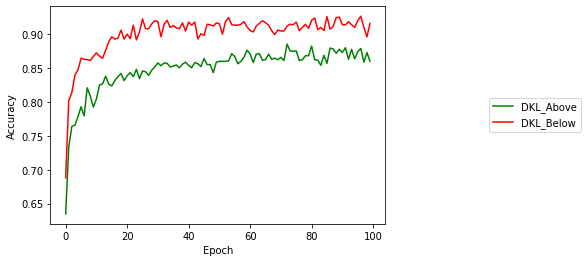

In [36]:
fig1 = plt.figure()



plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('densenet121_glcm_homogeneity_DKL_accuracy_coviddataset.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


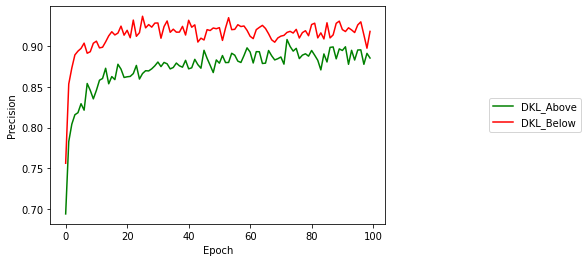

In [38]:
fig1 = plt.figure()


plt.plot(history2.history['precision'], color='g')
plt.plot(history.history['precision'], color='r')

plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('densenet121_glcm_homogeneity_DKL_precision_coviddataset.eps',  dpi=1000, format="eps", bbox_inches="tight") 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


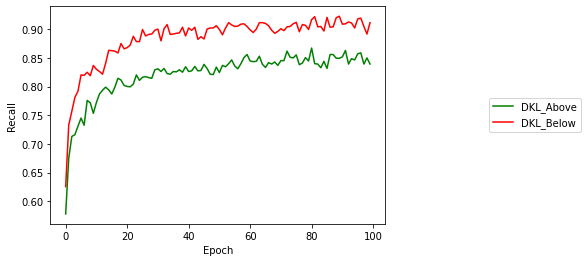

In [40]:
fig1 = plt.figure()

plt.plot(history2.history['recall'], color='g')
plt.plot(history.history['recall'], color='r')

plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('densenet121_glcm_homogeneity_DKL_recall_coviddataset.eps',  dpi=1000, format="eps", bbox_inches="tight") 
